In [ ]:
pip install datasets transformers seqeval evaluate

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/scaled_sentences_entities.csv"
sentence_entities = pd.read_csv(data_dir)

Mounted at /content/drive


## Hugging Face Transformer `dslim/bert-base-NER`

In [ ]:
import numpy as np
import random
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments,
    DataCollatorForTokenClassification
)
from seqeval.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from transformers import EarlyStoppingCallback
import os
import ast

model = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(model)

def align_tokens_with_labels(sentence, entities):
    tokens = tokenizer.tokenize(sentence)
    labels = ['O'] * len(tokens)

    for entity_text, entity_type in entities:
        entity_tokens = tokenizer.tokenize(entity_text)
        for i in range(len(tokens)):
            if tokens[i:i+len(entity_tokens)] == entity_tokens:
                labels[i] = f'B-{entity_type}'
                for j in range(1, len(entity_tokens)):
                    labels[i+j] = f'I-{entity_type}'
    return tokens, labels

def safe_eval_with_index(row):
    try:
        return ast.literal_eval(row['entities'])
    except Exception as e:
        print(f"Error in row {row.name}: {row['entities']}\nError: {e}")
        return None

sentence_entities['entities'] = sentence_entities.apply(safe_eval_with_index, axis=1)

tokenized_data = []

for _, row in sentence_entities.iterrows():
    sentence = row['sentence']
    entities = row['entities']
    tokens, labels = align_tokens_with_labels(sentence, entities)
    tokenized_data.append({
        "tokens": tokens,
        "labels": labels
    })

processed_df = pd.DataFrame(tokenized_data)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
processed_df_df = processed_df.sample(frac=1, random_state=45).reset_index(drop=True)
processed_df_df.head()

,tokens,labels
0,"[Diana, /, Cara, ,, At, ##ta, ##ched, is, a, l...","[B-PERSON, O, B-PERSON, O, O, O, O, O, O, O, O..."
1,"[John, Anderson, will, be, in, at, 8, .]","[B-PERSON, I-PERSON, O, O, O, O, B-TIME, O]"
2,"[Questions, about, some, off, -, balance, shee...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[For, example, ,, we, were, the, leading, trad...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-GPE,..."
4,"[Riverside, was, unable, to, obtain, non, -, f...","[B-ORG, O, O, O, O, O, O, O, O, B-TIME, I-TIME..."


In [ ]:
# --- Configuration ---
MODEL_NAME = "dslim/bert-base-NER"
NUM_EPOCHS = 5
OUTPUT_DIR = "./ner_model_output"
LOGGING_DIR = "./logs"
BATCH_SIZE = 8
WEIGHT_DECAY = 0.01
RANDOM_STATE = 42
TARGET_ENTITY_TYPES = {"PERSON", "ORG", "GPE", "DATE", "TIME", "MONEY"}

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def prepare_data(token_labeled_df):
    train_df, val_df = train_test_split(
        token_labeled_df,
        test_size=0.2,
        random_state=RANDOM_STATE
    )
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True)

def tokenize_and_align_labels(examples, tokenizer, label2id):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # Option 1: Keep the label of the previous token
                label_ids.append(label2id[label[word_idx]])
            else:
                 # Option 2: Set to -100 to ignore subword tokens
                 label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

def build_label_maps(dataset):
    all_labels = [label for row in dataset["labels"] for label in row]
    unique_labels = sorted(set(all_labels))
    if 'O' not in unique_labels and any('O' in sublist for sublist in dataset["labels"]):
      unique_labels.append('O')
    id2label = {i: label for i, label in enumerate(unique_labels)}
    label2id = {label: i for i, label in id2label.items()}
    return id2label, label2id, len(unique_labels)


def tokenize_data(train_df, val_df, label_column="labels"):
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    id2label, label2id, num_labels = build_label_maps(train_dataset)
    train_dataset = train_dataset.map(
        lambda examples: tokenize_and_align_labels(examples, tokenizer, label2id),
        batched=True,
        remove_columns=train_dataset.column_names
    )
    val_dataset = val_dataset.map(
        lambda examples: tokenize_and_align_labels(examples, tokenizer, label2id),
        batched=True,
        remove_columns=val_dataset.column_names
    )
    return train_dataset, val_dataset, tokenizer, id2label, label2id, num_labels

def compute_metrics(p, id2label):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [
        [id2label[l] for l in label if l != -100]
        for label in labels
    ]
    true_preds = [
        [id2label[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]

    filtered_true = []
    filtered_pred = []
    for t_seq, p_seq in zip(true_labels, true_preds):
        temp_true = []
        temp_pred = []
        for t, p in zip(t_seq, p_seq):
            if t != "O":
                temp_true.append(t)
                temp_pred.append(p)
        if temp_true:
            filtered_true.append(temp_true)
            filtered_pred.append(temp_pred)

    return {
        "precision": precision_score(filtered_true, filtered_pred),
        "recall": recall_score(filtered_true, filtered_pred),
        "f1": f1_score(filtered_true, filtered_pred),
        "accuracy": accuracy_score(filtered_true, filtered_pred),
    }


def train_model(train_dataset, val_dataset, tokenizer, num_labels, id2label, label2id):
    print("Training NER model with ", MODEL_NAME, ' ....\n')
    model = AutoModelForTokenClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )

    args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        logging_dir=LOGGING_DIR,
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        weight_decay=WEIGHT_DECAY,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        seed=RANDOM_STATE,
        logging_steps=10,
        logging_first_step=True
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer),
        compute_metrics=lambda p: compute_metrics(p, id2label),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()
    trainer.save_model(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
    print("Model and tokenizer saved.")
    return trainer


In [ ]:
set_seed(RANDOM_STATE)
train_df, val_df = prepare_data(processed_df)
train_dataset, val_dataset, tokenizer, id2label, label2id, num_labels = tokenize_data(train_df, val_df)
os.environ["WANDB_DISABLED"] = "true"
trainer = train_model(train_dataset, val_dataset, tokenizer, num_labels, id2label, label2id)

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

Map:   0%|          | 0/317 [00:00<?, ? examples/s]

Training NER model with  dslim/bert-base-NER  ....



model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.291000,0.231014,0.771626,0.763045,0.767312,0.803107
2,0.178100,0.219260,0.831665,0.781865,0.805996,0.822720
3,0.111000,0.219318,0.833190,0.828914,0.831046,0.880795
4,0.054700,0.237316,0.829141,0.817793,0.823428,0.863474


Model and tokenizer saved.


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from transformers.trainer_utils import EvalPrediction
from seqeval.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from seqeval.metrics.sequence_labeling import get_entities

def evaluate_model_with_matrix(trainer, val_dataset, id2label):
    print("Running evaluation on validation set...")
    outputs = trainer.predict(val_dataset)

    prediction_obj = EvalPrediction(
        predictions=outputs.predictions,
        label_ids=outputs.label_ids,
    )

    metrics = compute_metrics(prediction_obj, id2label)

    predictions = np.argmax(outputs.predictions, axis=2)
    labels = outputs.label_ids

    true_labels = [
        [id2label[l] for l in label if l != -100]
        for label in labels
    ]
    true_preds = [
        [id2label[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]

    print("\nClassification Report (Excluding 'O'):")

    filtered_true = []
    filtered_pred = []
    for seq_true, seq_pred in zip(true_labels, true_preds):
        temp_true, temp_pred = [], []
        for t, p in zip(seq_true, seq_pred):
            if t != 'O':
                temp_true.append(t)
                temp_pred.append(p)
        if temp_true:
            filtered_true.append(temp_true)
            filtered_pred.append(temp_pred)

    # entity-level classification report
    print(classification_report(filtered_true, filtered_pred, digits=3))

    true_entities = [get_entities(seq) for seq in filtered_true]
    pred_entities = [get_entities(seq) for seq in filtered_pred]

    true_flat = [ent[0] for seq in true_entities for ent in seq]
    pred_flat = [ent[0] for seq in pred_entities for ent in seq]

    entity_labels = sorted(set(true_flat + pred_flat))

    conf_matrix_df = pd.crosstab(
        pd.Series(true_flat, name="True"),
        pd.Series(pred_flat, name="Predicted"),
        rownames=["True"],
        colnames=["Predicted"],
        dropna=False
    ).reindex(index=entity_labels, columns=entity_labels, fill_value=0)

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_df.values, display_labels=entity_labels)
    disp.plot(xticks_rotation=90, cmap="viridis")
    plt.title("Entity-Level Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return metrics


Running evaluation on validation set...



Classification Report (Excluding 'O'):
              precision    recall  f1-score   support

        DATE      0.823     0.863     0.842       226
         GPE      0.930     0.757     0.835        70
       MONEY      0.891     0.840     0.865       194
         ORG      0.839     0.727     0.779       373
      PERSON      0.838     0.798     0.817       168
        TIME      0.705     0.710     0.708       138

   micro avg      0.832     0.782     0.806      1169
   macro avg      0.837     0.782     0.808      1169
weighted avg      0.834     0.782     0.806      1169



<Figure size 800x600 with 0 Axes>

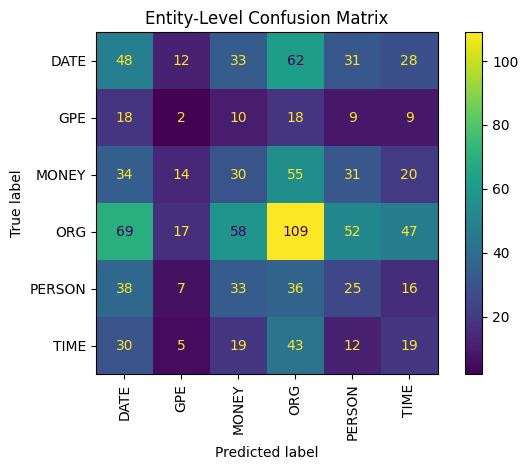


Final Evaluation Metrics:
precision: 0.8317
recall: 0.7819
f1: 0.8060
accuracy: 0.8227


In [ ]:
import warnings
from seqeval.metrics import sequence_labeling

warnings.filterwarnings("ignore", category=UserWarning, module='seqeval.metrics.sequence_labeling')

metrics = evaluate_model_with_matrix(trainer, val_dataset, id2label)
print("\nFinal Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

## Masked Language Modeling (MLM)

In [ ]:
from transformers import (
    BertTokenizerFast,
    BertForMaskedLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
import torch
import math
import os
import pandas as pd

sentences_mask = pd.read_csv("/content/drive/MyDrive/sentence_entities.csv")
sentences_mask = sentences_mask[7000:19000]
sentences_mask.reset_index(drop=True, inplace=True)

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

hf_dataset = Dataset.from_pandas(sentences_mask)

tokenized_dataset = hf_dataset.map(tokenize_function, batched=True, remove_columns=["sentence"])

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [ ]:
os.environ["WANDB_DISABLED"] = "true"
model = BertForMaskedLM.from_pretrained("bert-base-cased")
training_args = TrainingArguments(
    output_dir="./mlm-enron-bert-base",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=500,
    save_total_limit=1,
    logging_steps=100,
    eval_strategy="no",
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)


trainer.train()


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-9-1872887808.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0

Step,Training Loss
100,2.734600
200,2.603400
300,2.528200
400,2.462300
500,2.519500
600,2.464200
700,2.471100
800,2.329900
900,2.269400
1000,2.234700


TrainOutput(global_step=2250, training_loss=2.3159077996148003, metrics={'train_runtime': 1027.091, 'train_samples_per_second': 35.05, 'train_steps_per_second': 2.191, 'total_flos': 2368801124352000.0, 'train_loss': 2.3159077996148003, 'epoch': 3.0})

In [ ]:
trainer.save_model("mlm-enron-bert-base")
tokenizer.save_pretrained("mlm-enron-bert-base")

('mlm-enron-bert-base/tokenizer_config.json',
 'mlm-enron-bert-base/special_tokens_map.json',
 'mlm-enron-bert-base/vocab.txt',
 'mlm-enron-bert-base/added_tokens.json',
 'mlm-enron-bert-base/tokenizer.json')

In [ ]:
# load for NER fine-tuning
from transformers import AutoModelForTokenClassification
MODEL_NAME = "./mlm-enron-bert-base"
OUTPUT_DIR = "./mlm_ner_model_output"
set_seed(RANDOM_STATE)
train_df_mlm, val_df_mlm = prepare_data(processed_df)
train_dataset_mlm, val_dataset_mlm, tokenizer_mlm, id2label_mlm, label2id_mlm, num_labels_mlm = tokenize_data(train_df_mlm, val_df_mlm)
os.environ["WANDB_DISABLED"] = "true"
trainer_2 = train_model(train_dataset_mlm, val_dataset_mlm, tokenizer_mlm, num_labels_mlm, id2label_mlm, label2id_mlm)


Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

Map:   0%|          | 0/317 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ./mlm-enron-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training NER model with  ./mlm-enron-bert-base  ....



/tmp/ipython-input-5-1283235997.py:140: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.292800,0.229280,0.746018,0.761334,0.753599,0.813296
2,0.192100,0.205704,0.811943,0.779299,0.795286,0.828069
3,0.115000,0.201817,0.824936,0.826347,0.825641,0.881049
4,0.044900,0.224206,0.828821,0.811805,0.820225,0.864493
5,0.075400,0.238648,0.823176,0.820359,0.821765,0.874172


Model and tokenizer saved.


Running evaluation on validation set...



Classification Report (Excluding 'O'):
              precision    recall  f1-score   support

        DATE      0.800     0.885     0.840       226
         GPE      0.846     0.786     0.815        70
       MONEY      0.844     0.809     0.826       194
         ORG      0.865     0.823     0.843       373
      PERSON      0.831     0.881     0.855       168
        TIME      0.735     0.725     0.730       138

   micro avg      0.826     0.827     0.827      1169
   macro avg      0.820     0.818     0.818      1169
weighted avg      0.828     0.827     0.827      1169



<Figure size 800x600 with 0 Axes>

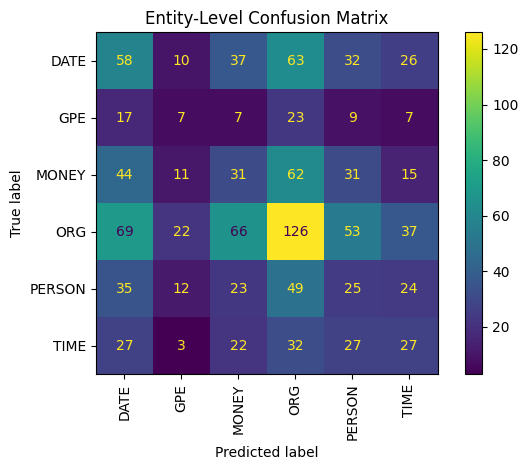


Final Evaluation Metrics:
precision: 0.8265
recall: 0.8272
f1: 0.8268
accuracy: 0.8805


In [ ]:
metrics = evaluate_model_with_matrix(trainer_2, val_dataset_mlm, id2label_mlm)
print("\nFinal Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

### MLM- Extend the Sentence Mask Size

In [ ]:
sentences_mask_extend = pd.read_csv("/content/drive/MyDrive/sentence_entities.csv")
sentences_mask_extend = sentences_mask_extend[5000:19000]

sentences_mask_extend.reset_index(drop=True, inplace=True)

hf_dataset_extend = Dataset.from_pandas(sentences_mask_extend)

tokenized_dataset_extend = hf_dataset_extend.map(tokenize_function, batched=True, remove_columns=["sentence"])


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

In [ ]:
os.environ["WANDB_DISABLED"] = "true"
model = BertForMaskedLM.from_pretrained("bert-base-cased")
training_args = TrainingArguments(
    output_dir="./mlm-enron-bert-base_v2",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=500,
    save_total_limit=1,
    logging_steps=100,
    eval_strategy="no",
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_extend,
    tokenizer=tokenizer,
    data_collator=data_collator
)


trainer.train()

trainer.save_model("mlm-enron-bert-base_v2")
tokenizer.save_pretrained("mlm-enron-bert-base_v2")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-14-2410705794.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.

Step,Training Loss
100,2.690100
200,2.640000
300,2.557100
400,2.547600
500,2.524300
600,2.530600
700,2.480100
800,2.427700
900,2.393600
1000,2.360500


('mlm-enron-bert-base_v2/tokenizer_config.json',
 'mlm-enron-bert-base_v2/special_tokens_map.json',
 'mlm-enron-bert-base_v2/vocab.txt',
 'mlm-enron-bert-base_v2/added_tokens.json',
 'mlm-enron-bert-base_v2/tokenizer.json')

In [ ]:
# NER fine-tuning
from transformers import AutoModelForTokenClassification
MODEL_NAME = "./mlm-enron-bert-base_v2"
OUTPUT_DIR = "./mlm_ner_bert"
set_seed(RANDOM_STATE)
train_df_mlm, val_df_mlm = prepare_data(processed_df)
train_dataset_mlm, val_dataset_mlm, tokenizer_mlm, id2label_mlm, label2id_mlm, num_labels_mlm = tokenize_data(train_df_mlm, val_df_mlm)
os.environ["WANDB_DISABLED"] = "true"
trainer_3 = train_model(train_dataset_mlm, val_dataset_mlm, tokenizer_mlm, num_labels_mlm, id2label_mlm, label2id_mlm)

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

Map:   0%|          | 0/317 [00:00<?, ? examples/s]

Training NER model with  ./mlm-enron-bert-base_v2  ....



Some weights of BertForTokenClassification were not initialized from the model checkpoint at ./mlm-enron-bert-base_v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-5-3309269933.py:174: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.299300,0.236223,0.754113,0.745081,0.749570,0.800051
2,0.176800,0.209143,0.796134,0.775021,0.785436,0.823484
3,0.112700,0.200384,0.842513,0.837468,0.839983,0.879012
4,0.045500,0.216878,0.847234,0.825492,0.836222,0.865257
5,0.062200,0.226552,0.848908,0.831480,0.840104,0.874427


Model and tokenizer saved.


Running evaluation on validation set...



Classification Report (Excluding 'O'):
              precision    recall  f1-score   support

        DATE      0.839     0.898     0.868       226
         GPE      0.838     0.814     0.826        70
       MONEY      0.867     0.840     0.853       194
         ORG      0.867     0.823     0.845       373
      PERSON      0.828     0.887     0.856       168
        TIME      0.769     0.725     0.746       138

   micro avg      0.843     0.837     0.840      1169
   macro avg      0.835     0.831     0.832      1169
weighted avg      0.843     0.837     0.839      1169



<Figure size 800x600 with 0 Axes>

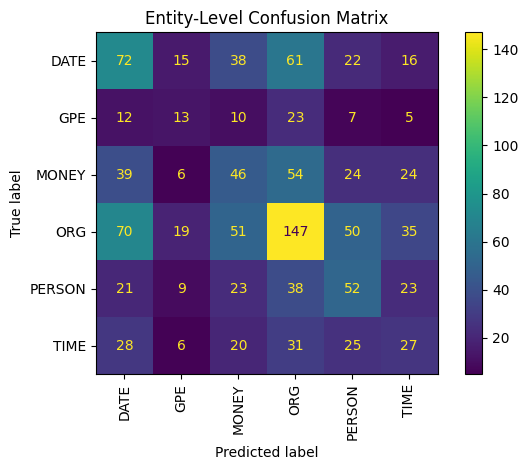


Final Evaluation Metrics:
precision: 0.8425
recall: 0.8375
f1: 0.8400
accuracy: 0.8790


In [ ]:
metrics = evaluate_model_with_matrix(trainer_3, val_dataset_mlm, id2label_mlm)
print("\nFinal Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

In [ ]:
trainer_3.model.config.id2label = id2label_mlm
trainer_3.model.config.label2id = label2id_mlm

trainer_3.save_model("./mlm_ner_bert")
tokenizer_mlm.save_pretrained("./mlm_ner_bert")


('./mlm_ner_bert/tokenizer_config.json',
 './mlm_ner_bert/special_tokens_map.json',
 './mlm_ner_bert/vocab.txt',
 './mlm_ner_bert/added_tokens.json',
 './mlm_ner_bert/tokenizer.json')

**General Conclusion:**

Increasing the amount of unlabeled domain text from 12k to 14k led to a modest but consistent improvement in accuracy, recall, and overall F1. While some entity-specific F1 scores (like ORG) slightly dropped, the 14k model showed better generalization and span recognition across the board.

In [ ]:
import os
source_folder = '/content/mlm_ner_bert'

if os.path.exists(source_folder):
    print(f"Checking the size of '{source_folder}'...")
    !du -sh "$source_folder"
else:
    print(f"Error: Folder '{source_folder}' not found. Please ensure it exists.")

destination_folder = '/content/drive/MyDrive/mlm_ner_bert'

print(f"Copying '{source_folder}' to '{destination_folder}'...")
!cp -r "$source_folder" "$destination_folder"

print("\nCopy complete!")
print(f"You should now find your model at: {destination_folder}")

Checking the size of '/content/mlm_ner_bert'...
1.7G	/content/mlm_ner_bert
Copying '/content/mlm_ner_bert' to '/content/drive/MyDrive/mlm_ner_bert'...

Copy complete!
You should now find your model at: /content/drive/MyDrive/mlm_ner_bert
